# PHY294 Franck-Hertz Experiment
### This notebook will plot the experimental data, find the line of best fit, and calculate goodness of fit criterion

#### Imports

In [8]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.optimize as optimize

#### Read in data to pandas df

In [4]:
file_paths = glob.glob('/Users/lucaschoi/Documents/GitHub/PHY294-Franck-Hertz/data/*.csv')
dataframes = {}
E2_voltages = []

for path in file_paths:
    if 'old' not in path:
        voltage = path.split('/')[-1].replace('.csv', '')
        data = pd.read_csv(path)
        dataframes[float(voltage)] = data
        E2_voltages.append(float(voltage))

E2_voltages = sorted(E2_voltages)

### Plot the different trials

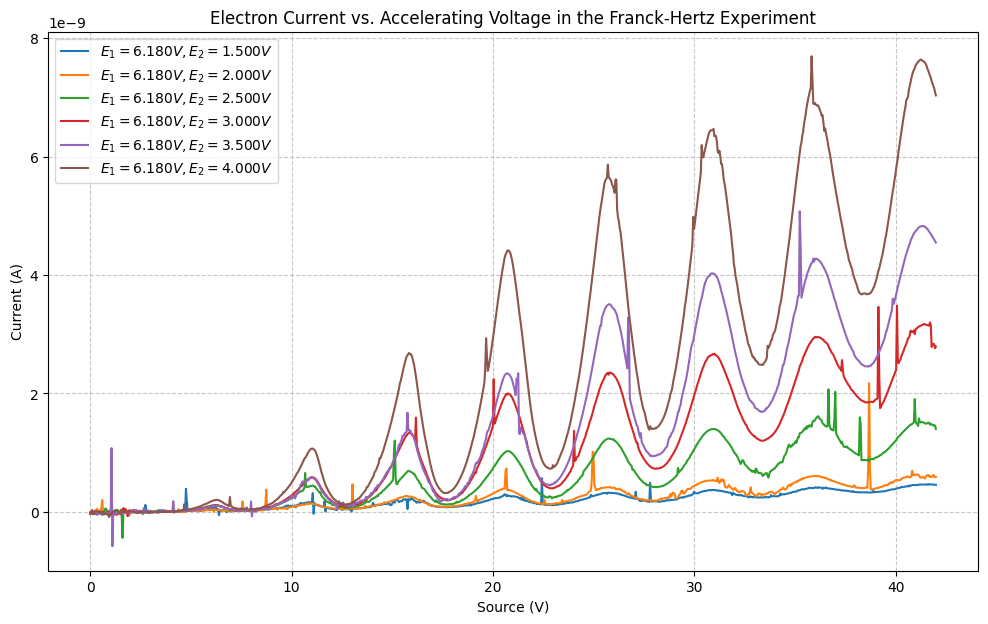

In [5]:
plt.figure(figsize=(12, 7))
for voltage in E2_voltages:

    data = dataframes[voltage]
    plt.plot(data['CH2 Voltage'], data['CH1 Current'], label=f'$E_1= 6.180 V, E_2 = {voltage:.3f} V$')

plt.xlabel('Source (V)')
plt.ylabel('Current (A)')
plt.title('Electron Current vs. Accelerating Voltage in the Franck-Hertz Experiment')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### From here forward, we choose to use the $E_2 = 4.000V$ data since the peaks are the best defined

### Find peaks

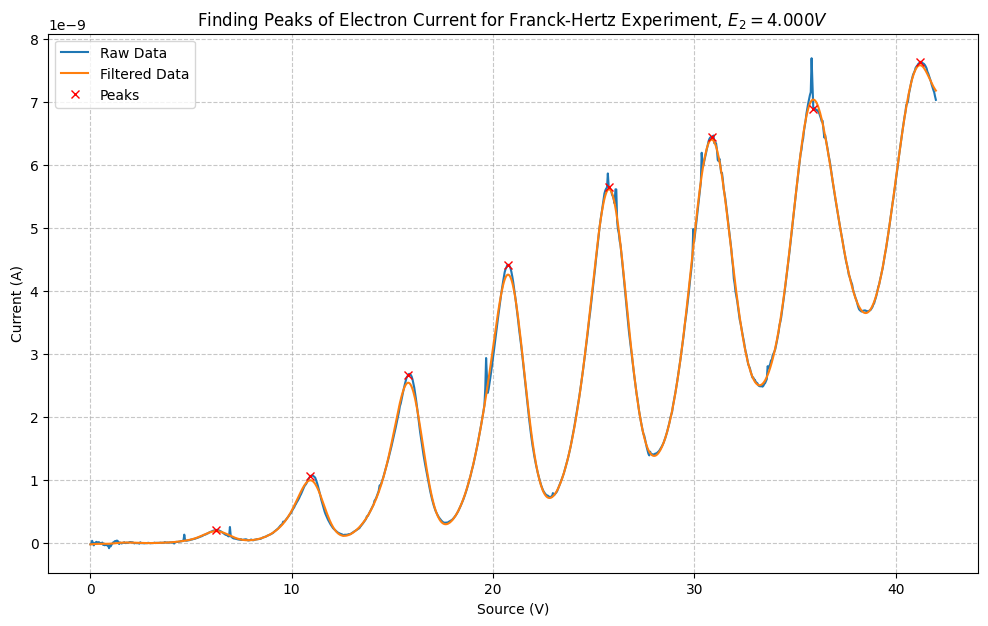

[149 260 376 494 613 735 855 981]


In [53]:
x = dataframes[4.0]['CH2 Voltage']
y = dataframes[4.0]['CH1 Current']
dx = 0.0005
dy = 0.05 * 10**-13

# apply a bandpass filter
b, a = signal.butter(3, 0.05)
y_filtered = signal.filtfilt(b, a, y)

peaks, _ = signal.find_peaks(y_filtered, height= 1 * 10**-11)

plt.figure(figsize=(12, 7))
plt.plot(x, y, label='Raw Data')
plt.plot(x, y_filtered, label='Filtered Data')
plt.plot(x[peaks], y[peaks], 'rx', label='Peaks')
plt.xlabel('Source (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Finding Peaks of Electron Current for Franck-Hertz Experiment, $E_2 = 4.000V$ ')
plt.show()
print(peaks)



### Fit the peaks

Linear Fit: $V = 5.0865V \pm 0.0294V$ + 5.6280V \pm 0.1229V$
R^2: 0.9997997307697558
Reduced Chi Squared: 145109.99999999694
Peak #: 1, Sweeping Voltage: 5.796V \pm 0.001V
Peak #: 2, Sweeping Voltage: 10.794V \pm 0.001V, Difference: 4.998V \pm 0.001
Peak #: 3, Sweeping Voltage: 15.792V \pm 0.001V, Difference: 4.998V \pm 0.001
Peak #: 4, Sweeping Voltage: 20.706V \pm 0.001V, Difference: 4.914V \pm 0.001
Peak #: 5, Sweeping Voltage: 25.788V \pm 0.001V, Difference: 5.082V \pm 0.001
Peak #: 6, Sweeping Voltage: 30.912V \pm 0.001V, Difference: 5.124V \pm 0.001
Peak #: 7, Sweeping Voltage: 36.120V \pm 0.001V, Difference: 5.208V \pm 0.001
Peak #: 8, Sweeping Voltage: 41.538V \pm 0.001V, Difference: 5.418V \pm 0.001
Weighted Mean: 5.1060 V +/- 0.0002 V


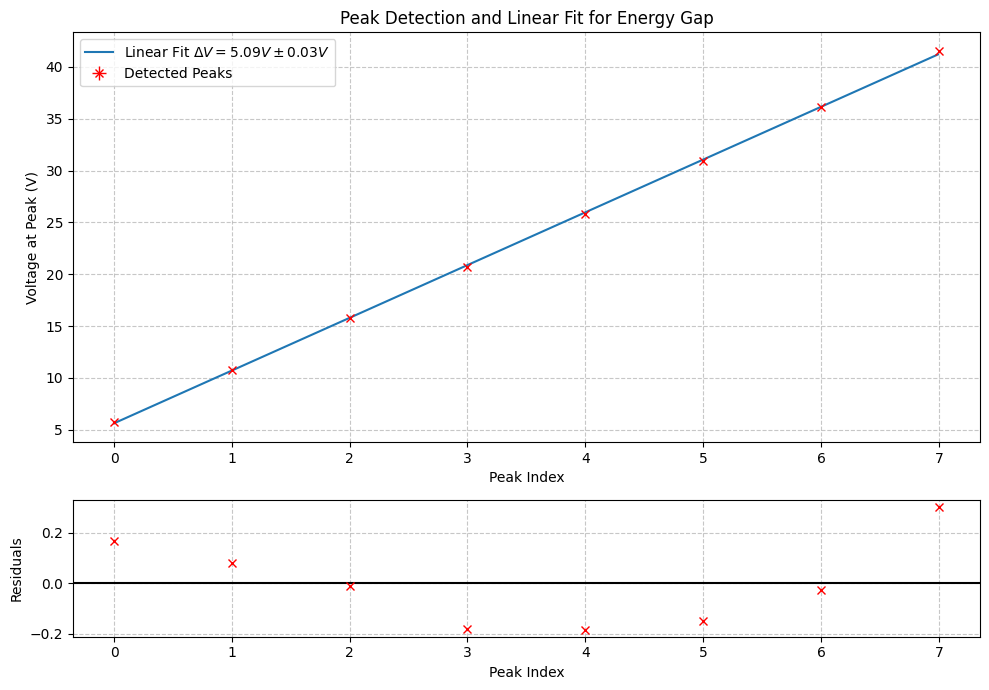

In [137]:
peak_voltages = dataframes[4.0]['CH2 Voltage'][peaks]
peak_index = [i for i in range(len(peaks))]
Verr = 0.0005

def linear(x, m, b):
    return m * x + b

popt, pcov = optimize.curve_fit(linear, peak_index, peak_voltages)
m, b = popt

puncert = np.sqrt(np.diagonal(pcov))  
V_unc = puncert[0]
b_unc = puncert[1]  
print(f'Linear Fit: $V = {m:.4f}V \pm {V_unc:.4f}V$ + {b:.4f}V \pm {b_unc:.4f}V$')



start = min(peak_index)
stop = max(peak_index)    
xs = np.arange(start,stop,(stop-start)/1000) 
curve = linear(xs, *popt) 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(peak_index, peak_voltages, yerr=Verr, xerr=0, fmt='rx', label='Detected Peaks', lw=1)
ax1.plot(xs, curve, label=f'Linear Fit $\Delta V = {m:.2f}V \pm {V_unc:.2f}V$')
ax1.legend(loc='upper left')
ax1.set_xlabel('Peak Index')
ax1.set_ylabel('Voltage at Peak (V)')
ax1.set_title('Peak Detection and Linear Fit for Energy Gap')
ax1.grid(True, linestyle='--', alpha=0.7)

ax2.grid(True, linestyle='--', alpha=0.7)
residual = peak_voltages - linear(np.array(peak_index), *popt)
ax2.errorbar(peak_index, residual, yerr=Verr, xerr=0, fmt="rx", lw=1)
ax2.axhline(y=0, color="black")    
ax2.set_xlabel('Peak Index')
ax2.set_ylabel("Residuals")
fig.tight_layout()




y_fit = np.array(peak_index) * m + b
residuals = np.array(peak_voltages) - y_fit
ss_res = sum(residuals**2)
y_mean = sum(peak_voltages) / len(peak_voltages)
ss_tot = sum((peak_voltages - y_mean)**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R^2: {r_squared}')

numerator = residuals**2
denominator = Verr**2
frac = numerator/denominator
chi_squared = sum(frac)
reduced_chi_squared = chi_squared / (len(peak_index) - 2)
print(f'Reduced Chi Squared: {reduced_chi_squared}')

prev_v = 0
diffs = []
for i, v in enumerate(peak_voltages):
    
    if i == 0:
        print(f'Peak #: {i + 1}, Sweeping Voltage: {v:.3f}V \pm {Verr:.3f}V')
    else:
        diff = v - prev_v
        print(f'Peak #: {i + 1}, Sweeping Voltage: {v:.3f}V \pm {Verr:.3f}V, Difference: {diff:.3f}V \pm {Verr:.3f}' )
        diffs.append(diff)
    prev_v = v

dV = [Verr for i in range(len(peak_voltages)-1)]
weighted_mean = np.average(np.array(diffs), weights=[1/i**2 for i in dV])
weighted_mean_unc = np.sqrt(1/sum([1/i**2 for i in dV]))
print(f'Weighted Mean: {weighted_mean:.4f} V +/- {weighted_mean_unc:.4f} V')


### Find $\Delta V$ for all trials



In [110]:
delta_v = []
delta_v_unc = []
for df in dataframes:
    x = dataframes[df]['CH2 Voltage']
    y = dataframes[df]['CH1 Current']
    dx = 0.0005
    dy = 0.05 * 10**-13

    # apply a bandpass filter
    b, a = signal.butter(3, 0.05)
    y_filtered = signal.filtfilt(b, a, y)

    peaks, _ = signal.find_peaks(y_filtered, height= 1 * 10**-11)

    peak_voltages = x[peaks]
    peak_index = [i for i in range(len(peaks))]
    Verr = 0.0005

    popt, pcov = optimize.curve_fit(linear, peak_index, peak_voltages)
    m, b = popt

    puncert = np.sqrt(np.diagonal(pcov))  
    V_unc = puncert[0]
    b_unc = puncert[1]  



    delta_v.append(m)
    delta_v_unc.append(V_unc)

print(delta_v)
print(delta_v_unc)
print(np.mean(delta_v))
weighted_mean = np.average(delta_v, weights=[1/i**2 for i in delta_v_unc])
weighted_mean_unc = np.sqrt(1/sum([1/i**2 for i in delta_v_unc]))
print(f'Weighted Mean: {weighted_mean:.2f} V +/- {weighted_mean_unc:.2f} V')


[4.997499998410661, 5.016000000008759, 4.212981818188826, 5.0350000000088, 4.80060000000829, 5.086499998800222]
[0.032818948131831005, 0.02990819298890721, 0.1309934654738047, 0.03361299316751962, 0.12936866072810127, 0.02938962472176991]
4.858096969237593
Weighted Mean: 5.02 V +/- 0.02 V


### Fit the curve



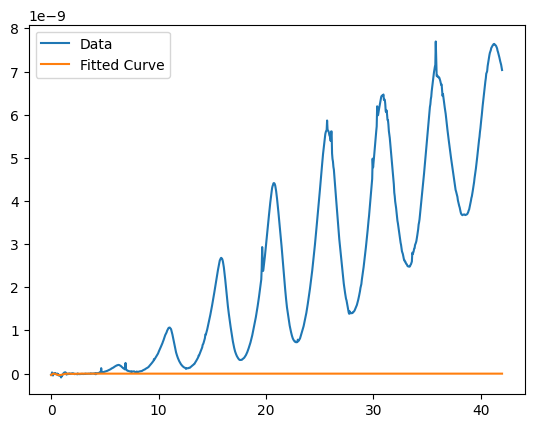

[-1.02619355e-10  2.44617188e+00 -5.92978476e-01  1.34279255e+00]
[[ 8.11899623e-17  2.88585810e-07 -1.31744471e-07 -7.91714222e-07]
 [ 2.88585810e-07  2.55988994e+03 -9.92184247e+02 -2.78234451e+03]
 [-1.31744471e-07 -9.92184247e+02  6.21098639e+02  1.35509293e+03]
 [-7.91714222e-07 -2.78234451e+03  1.35509293e+03  8.80555762e+03]]


In [17]:
x = dataframes[4.0]['CH2 Voltage']
y = dataframes[4.0]['CH1 Current']

def fit(x, a, b, c, d):
    return a * np.sin(b * x + c) ** 2 * (np.exp(-d * x))

popt, pcov = optimize.curve_fit(fit, x, y, p0=[1, 1, 1, 0.5])
plt.plot(x, y, label='Data')
plt.plot(x, fit(x, *popt), label='Fitted Curve')
plt.legend()
plt.show()